### Imports and Definitions

In [1]:
from datetime import datetime
from glob import glob
from gzip import open as gopen
from math import exp,log,log10
from matplotlib import rcParams
from matplotlib.cm import Reds,ScalarMappable
from matplotlib.collections import PolyCollection
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from matplotlib.scale import LinearScale,register_scale,ScaleBase
from matplotlib.transforms import Transform
from numpy import array,cbrt,linspace,nan_to_num,sqrt
from os.path import isfile
from pickle import load,dump
from random import sample,shuffle
from scipy.stats import kendalltau
from seaborn import boxenplot,boxplot,pointplot,set_context,set_style,stripplot,swarmplot,violinplot
from treeswift import read_tree_newick
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
FIGDIR = '../figs'
TN93THRESH = 0.015
SIMTIME = 10 # simulations were 10 years
RC = {"font.size":12,"axes.titlesize":16,"axes.labelsize":14,"legend.fontsize":10,"xtick.labelsize":10,"ytick.labelsize":10}
set_context("paper", rc=RC); set_style("ticks"); rcParams['font.family'] = 'serif'

In [2]:
def p_to_star(p):
    if p <= 0.0001:
        return '****'
    elif p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    elif p <= 0.05:
        return '*'
    else:
        return ''

def avg(x):
    return sum(x)/len(x)

### Custom Matplotlib Square-Root Scale

In [3]:
class SquareRootScale(ScaleBase):
    name = 'squareroot'

    def __init__(self, axis, **kwargs):
        ScaleBase.__init__(self)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax

    class SquareRootTransform(Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a):
            return nan_to_num(sqrt(array(a)), 0)

        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()

    class InvertedSquareRootTransform(Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return array(a)**2

        def inverted(self):
            return SquareRootScale.SquareRootTransform()

    def get_transform(self):
        return self.SquareRootTransform()
register_scale(SquareRootScale)

### Custom Matplotlib Cube-Root Scale

In [4]:
class CubeRootScale(ScaleBase):
    name = 'cuberoot'

    def __init__(self, axis, **kwargs):
        ScaleBase.__init__(self)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax

    class CubeRootTransform(Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return nan_to_num(cbrt(array(a)), 0)

        def inverted(self):
            return CubeRootScale.InvertedCubeRootTransform()

    class InvertedCubeRootTransform(Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return array(a)**3

        def inverted(self):
            return CubeRootScale.CubeRootTransform()

    def get_transform(self):
        return self.CubeRootTransform()
register_scale(CubeRootScale)

### Helper Function to Load FASTA

In [5]:
def read_FASTA(filename):
    seqs = {}
    name = None
    seq = ''
    if filename.lower().endswith('.gz'):
        f = gopen(filename)
    else:
        f = open(filename)
    for line in f:
        if isinstance(line,bytes):
            l = line.decode().strip()
        else:
            l = line.strip()
        if len(l) == 0:
            continue
        if l[0] == '>':
            if name is not None:
                assert len(seq) != 0, "Malformed FASTA"
                seqs[name] = seq
            name = l[1:]
            assert name not in seqs, "Duplicate sequence ID: %s" % name
            seq = ''
        else:
            seq += l
    f.close()
    assert name is not None and len(seq) != 0, "Malformed FASTA"
    seqs[name] = seq
    return seqs

### Helper Function to Load tn93 Output as Distance Matrix

In [6]:
def read_tn93(filename):
    dm = dict()
    if filename.lower().endswith('.gz'):
        f = gopen(filename)
    else:
        f = open(filename)
    for line in f:
        if isinstance(line,bytes):
            l = line.decode().strip()
        else:
            l = line.strip()
        u,v,d = l.split(',')
        if d == 'Distance':
            continue
        d = float(d)
        if u not in dm:
            dm[u] = dict()
        if v not in dm:
            dm[v] = dict()
        dm[u][v] = d; dm[v][u] = d
    return dm

### Helper Functions to Compute Cumulative Moving Average

In [7]:
# get the Cumulative Moving Average (CMA) over all indices
def cma(x):
    y = [x[0]]
    for i in range(1,len(x)):
        y.append(y[-1]+x[i])
    for i in range(len(y)):
        y[i] /= (i+1)
    return y

# helper function to compute the test statistic
def cma_test_stat(y,normalize=False):
    if normalize:
        sum_miny = sum(cma(sorted(x)))
        return (sum(y)-sum_miny)/(sum(cma(sorted(x,reverse=True)))-sum_miny) # AUC of CMA, normalized so min = 0 and max = 1
    else:
        return sum(y) # AUC of CMA

# returns (stat,p,cma_dist,stat_dist). "side" is "left" or "right"
def cma_test(x,side,bg_cma=None,bg_stat=None,it=1000):
    assert side in {'left','right'}, "'side' must be 'left' or 'right'"
    y = cma(x)
    stat = cma_test_stat(y)
    if bg_cma is None or bg_stat is None:
        cma_dist = list(); stat_dist = list()
        for _ in range(it):
            tmp = x[:]; shuffle(tmp); tmp_cma = cma(tmp)
            cma_dist.append(tmp_cma)
            stat_dist.append(cma_test_stat(tmp_cma))
    else:
        cma_dist = bg_cma; stat_dist = bg_stat
    if side == 'right':
        p = sum(e >= stat for e in stat_dist)/len(stat_dist)
    elif side == 'left':
        p = sum(e <= stat for e in stat_dist)/len(stat_dist)
    return stat,p,cma_dist,stat_dist

### Helper Functions to Kendall’s Tau Test

In [8]:
# compute the Kendall's tau
def tau(om):
    t,p = kendalltau(om, list(range(len(om)-1,-1,-1))) # p is 2-sided
    return (t,p/2.)

# returns (stat,p,stat_dist)
def tau_test(om,side,bg=None,it=1000):
    assert side in {'left','right'}, "'side' must be 'left' or 'right'"
    t,p = tau(om)
    if bg is None:
        tau_dist = list()
        for _ in range(it):
            tmp = om[:]; shuffle(tmp); tau_dist.append(tau(tmp)[0])
    else:
        tau_dist = bg
    #if side == 'right':
    #    p = sum(e >= t for e in tau_dist)/len(tau_dist)
    #elif side == 'left':
    #    p = sum(e <= t for e in tau_dist)/len(tau_dist)
    return t,p,tau_dist

# Efficacy on Real Data

### Load Data

In [9]:
data = {
    'seqs': read_FASTA('../real_data/sd.full.aln.gz'),
    'tn93': read_tn93('../real_data/sd.full.tn93.csv.gz'),
    'time': {t:{l.decode().strip().split()[0]:int(l.decode().strip().split()[1]) for l in gopen('../real_data/sd.time.%s.tsv.gz'%t)} for t in ['sample','diagnosis','infection']},
    'proact': {n:{t:gopen('../real_data/sd.%s.%s.mv.proact.txt.gz'%(n,t)).read().decode().strip().splitlines() for t in ['ft','iq']} for n in ['10','20','30','40','50','60','70','80','90','full']},
    'hivtrace': {n:gopen('../real_data/sd.%s.hivtrace.txt.gz'%n).read().decode().strip().splitlines() for n in ['10','20','30','40','50','60','70','80','90','full']},
}
metareal = {
    'label': {
        'ft': 'FastTree',
        'iq': 'IQ-TREE',
        'proact': 'ProACT',
        'max': 'Optimal',
        'bg': 'Null Distribution',
        'hivtrace': 'GD + Cluster Growth',
    },
    'color': {
        'proact.ft': 'blue',
        'proact.iq': 'red',
        'max': 'black',
        'bg': 'lightgrey',
        'hivtrace': 'orange',
    }
}
DATE = {per:max(datetime.strptime(l.split('_')[1], '%m-%d-%y') for l in data['proact'][per]['iq']) for per in data['proact']}

### Riskiness Score Functions

In [10]:
score_functions = {
    'function': {
        'logarithmic': lambda x: log(x+0.25)/log(0.25), # logarithmic where score = 0 at 75%
        'logistic': lambda x: 2.-2./(1.+exp(-x*log(3.)/0.015)), # logistic with 1/2 score at 1.5%
        'step': lambda x: {True:1,False:0}[x <= TN93THRESH], # step function at 1.5%
        
        # score = (L+1)/(L^(x/threshold)+L), with L = 1/(score at 2*threshold) for the following ones
        'sigmoid-L100': lambda x: (100.+1.)/(100.**(x/TN93THRESH)+100.), # score of 0.01 at 3%
        'sigmoid-L5': lambda x: (5.+1.)/(5.**(x/TN93THRESH)+5.), # score of 0.2 at 3%
    },
    'label': {
        'logarithmic': 'Logarithmic Function',
        'logistic': 'Logistic Function',
        'sigmoid-L100': r'Sigmoid Function $(\lambda=100)$',
        'sigmoid-L5': r'Sigmoid Function $(\lambda=5)$',
        'step': 'Step Function',
    },
}

def newnode_riskiness(u, end, score): # score is a function (one of the values of score_functions)
    if u not in data['tn93']:
        return 0
    return sum(score(data['tn93'][u][v]) for v in data['tn93'][u] if data['time'][s][v] > end)

SCOREFUNCS = ['step','sigmoid-L100','sigmoid-L5','logarithmic']

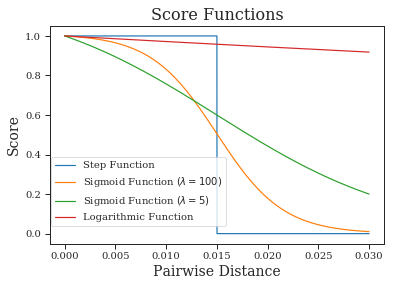

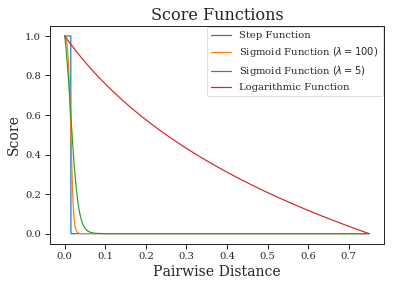

In [11]:
xmin = 0
ymin = None
ymax = None
for xmax in [TN93THRESH*2,0.75]:
    fig = plt.figure()
    x = linspace(xmin,xmax,100001)
    for scorekey in SCOREFUNCS:
        scorename = score_functions['label'][scorekey]; scorefunc = score_functions['function'][scorekey]
        y = [scorefunc(xi) for xi in x]
        plt.plot(x, y, label=scorename)
    plt.ylim(ymin=ymin,ymax=ymax)
    plt.title("Score Functions")
    plt.xlabel("Pairwise Distance")
    plt.ylabel("Score")
    if xmax < 0.1:
        plt.legend(bbox_to_anchor=(0.005, 0.08), loc=3, borderaxespad=0.)
        fig.savefig('%s/riskiness_score_functions_zoomed.pdf'%FIGDIR, format='pdf', bbox_inches='tight')
    else:
        plt.legend(bbox_to_anchor=(0.995, 0.995), loc=1, borderaxespad=0.)
        fig.savefig('%s/riskiness_score_functions.pdf'%FIGDIR, format='pdf', bbox_inches='tight')

### Kendall's Tau Test

========== Step Function ==========
ProACT (FastTree)
10-th Percentile: 0.346486 (p = 1e-05)
20-th Percentile: 0.309078 (p = 5e-08)
30-th Percentile: 0.234236 (p = 3e-07)
40-th Percentile: 0.257934 (p = 2e-10)
50-th Percentile: 0.175662 (p = 1e-06)
60-th Percentile: 0.158986 (p = 2e-06)
70-th Percentile: 0.115800 (p = 1e-04)
80-th Percentile: 0.073397 (p = 7e-03)
90-th Percentile: 0.139313 (p = 4e-07)

ProACT (IQ-TREE)
10-th Percentile: 0.382706 (p = 2e-06)
20-th Percentile: 0.299234 (p = 1e-07)
30-th Percentile: 0.229270 (p = 6e-07)
40-th Percentile: 0.256395 (p = 3e-10)
50-th Percentile: 0.171137 (p = 2e-06)
60-th Percentile: 0.151888 (p = 5e-06)
70-th Percentile: 0.121502 (p = 7e-05)
80-th Percentile: 0.074257 (p = 6e-03)
90-th Percentile: 0.137118 (p = 5e-07)

GD + Cluster Growth
10-th Percentile: 0.566542 (p = 4e-12)
20-th Percentile: 0.521071 (p = 1e-19)
30-th Percentile: 0.516934 (p = 3e-28)
40-th Percentile: 0.422306 (p = 7e-25)
50-th Percentile: 0.334952 (p = 2e-19)
60-th Perc

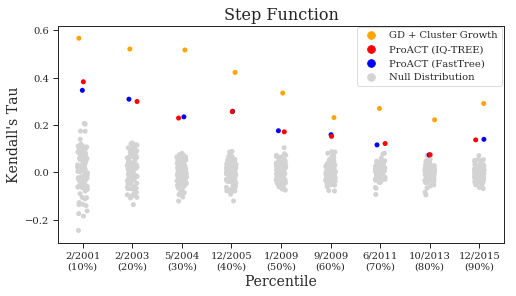

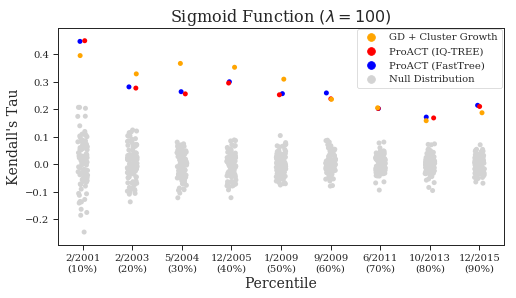

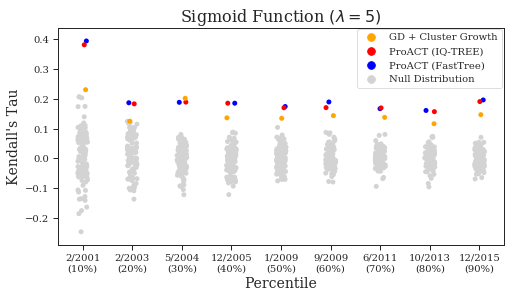

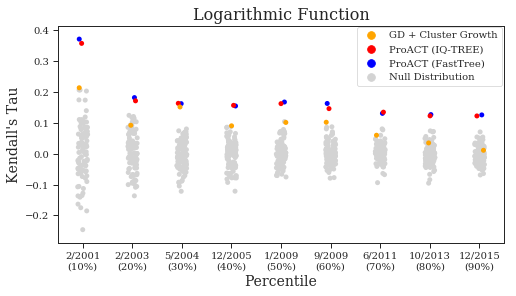

In [12]:
IT = 100; BG = dict()
Ts = ['proact.ft','proact.iq','hivtrace']
for scorekey in SCOREFUNCS:
    scorename = score_functions['label'][scorekey]; scorefunc = score_functions['function'][scorekey]
    print("="*10 + ' ' + scorename + ' ' + '='*10)
    ymin = None; ymax = None #ymin = -1; ymax = 1
    for s in ['sample']:
        fig = plt.figure(figsize=(8,4))
        x = list(); y = list(); hue = list(); pal = list(); tmp = list(); pal = [metareal['color']['bg']]
        for t in Ts:
            if t.endswith('.ft') or t.endswith('.iq'):
                label = "%s (%s)"%(metareal['label'][t.split('.')[0]],metareal['label'][t.split('.')[1]])
            else:
                label = metareal['label']['hivtrace']
            print(label)
            for per in ['10','20','30','40','50','60','70','80','90']:
                if per not in BG:
                    BG[per] = None
                if t.endswith('.ft') or t.endswith('.iq'):
                    currdata = data[t.split('.')[0]][per][t.split('.')[1]]
                else:
                    currdata = data['hivtrace'][per]
                END = max(int(l.split('_')[-1]) for l in currdata)
                val = [newnode_riskiness(u,END,scorefunc) for u in currdata]
                taustat,p,tau_dist = tau_test(val,'right',bg=BG[per],it=IT); BG[per] = tau_dist
                print("%s-th Percentile: %f (p = %s)" % (per,taustat,format(p,'.0e')))
                tmp.append((per,taustat,label,metareal['color'][t]))
            print()
        for per in BG:
            for bg in BG[per]:
                x.append("%s\n(%s%%)"%(DATE[per].strftime('%-m/%Y'),per))
                y.append(bg); hue.append(metareal['label']['bg'])
        for per,taustat,h,c in tmp:
            x.append("%s\n(%s%%)"%(DATE[per].strftime('%-m/%Y'),per))
            y.append(taustat); hue.append(h)
            if c not in pal:
                pal.append(c)
        stripplot(x=x,y=y,hue=hue,palette=pal,jitter=True)
        handles,labels = fig.gca().get_legend_handles_labels()
        plt.legend(handles[::-1],labels[::-1],bbox_to_anchor=(0.995, 0.995), loc=1, borderaxespad=0.)
        plt.ylim(ymin=ymin,ymax=ymax)
        plt.title(scorename)
        plt.xlabel("Percentile")
        plt.ylabel("Kendall's Tau")
        fig.savefig('%s/results_tautest_%s.pdf'%(FIGDIR,scorekey), format='pdf', bbox_inches='tight')

# Efficacy on Simulated Data

### Load Data

In [13]:
eff = load(gopen('../simulations/efficacy.pkl.gz'))
metasim = {
    'label': {
        'expected': 'Population Mean',
        'random': 'Random',
        'optimal': 'Optimal',
        'optimal.sub25': 'Optimal (25%)',
        'optimal.sub50': 'Optimal (50%)',
        'optimal.sub75': 'Optimal (75%)',
        'hivtrace': 'Cluster Growth',
        'hivtrace.sub25': 'Cluster Growth (25%)',
        'hivtrace.sub50': 'Cluster Growth (50%)',
        'hivtrace.sub75': 'Cluster Growth (75%)',
        'proact.true': 'ProACT (True Trees)',
        'proact.ftmv': 'ProACT',
        'proact.ftmv.sub25': 'ProACT (25%)',
        'proact.ftmv.sub50': 'ProACT (50%)',
        'proact.ftmv.sub75': 'ProACT (75%)',
        'branchlength.true': 'Branch Length (True Trees)',
        'branchlength.ftmv': 'Branch Length (FastTree)',
        'SAMPLE-END_ARTRATE-1': r'ART Rate 1 year$^{-1}$ (Sample End)',
        'SAMPLE-END_ARTRATE-2': r'ART Rate 2 year$^{-1}$ (Sample End)',
        'SAMPLE-END_ARTRATE-4': r'ART Rate 4 year$^{-1}$ (Sample End)',
        'SAMPLE-FIRSTART_ARTRATE-0.5': r'ART Rate 0.5 year$^{-1}$',
        'SAMPLE-FIRSTART_ARTRATE-1': r'ART Rate 1 year$^{-1}$',
        'SAMPLE-FIRSTART_ARTRATE-2': r'ART Rate 2 year$^{-1}$',
        'SAMPLE-FIRSTART_ARTRATE-4': r'ART Rate 4 year$^{-1}$',
        'SAMPLE-FIRSTART_EXPDEGREE-10': 'Expected Degree 10',
        'SAMPLE-FIRSTART_EXPDEGREE-20': 'Expected Degree 20',
        'SAMPLE-FIRSTART_EXPDEGREE-30': 'Expected Degree 30',
        'SAMPLE-FIRSTART_STOPRATE-0.25x': 'ART Stop Rate 0.25x',
        'SAMPLE-FIRSTART_STOPRATE-0.5x': 'ART Stop Rate 0.5x',
        'SAMPLE-FIRSTART_STOPRATE-1x': 'ART Stop Rate 1x',
        'SAMPLE-FIRSTART_STOPRATE-2x': 'ART Stop Rate 2x',
        'SAMPLE-FIRSTART_STOPRATE-4x': 'ART Stop Rate 4x',
    },
    'color': {
        'expected': 'lightgrey',
        'random': 'lightgrey',
        'optimal': 'black',
        'optimal.sub25': 'red',
        'optimal.sub50': 'orange',
        'optimal.sub75': 'gold',
        'hivtrace': 'darkgoldenrod',
        'hivtrace.sub25': 'cornsilk',
        'hivtrace.sub50': 'khaki',
        'hivtrace.sub75': 'goldenrod',
        'proact.true': 'chocolate',
        'proact.ftmv': 'darkblue',
        'proact.ftmv.sub25': 'aqua',
        'proact.ftmv.sub50': 'dodgerblue',
        'proact.ftmv.sub75': 'blue',
        'branchlength.true': 'lightgreen',
        'branchlength.ftmv': 'green',
    },
    'linestyle': {
        'expected': '--',
        'random': '--',
        'optimal': '--',
        'optimal.sub25': '--',
        'optimal.sub50': '--',
        'optimal.sub75': '--',
        'hivtrace': '-.',
        'hivtrace.sub25': '-.',
        'hivtrace.sub50': '-.',
        'hivtrace.sub75': '-.',
        'proact.true': '-',
        'proact.ftmv': '-',
        'proact.ftmv.sub25': '-',
        'proact.ftmv.sub50': '-',
        'proact.ftmv.sub75': '-',
        'branchlength.true': '-',
        'branchlength.ftmv': '-',
    }
}

## Metric: Number of Infections After Year 9

### Comparing Methods

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/usr/loc

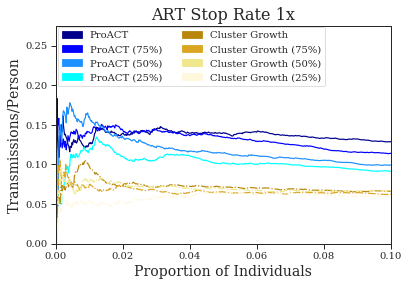

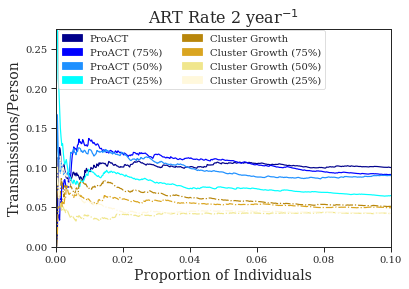

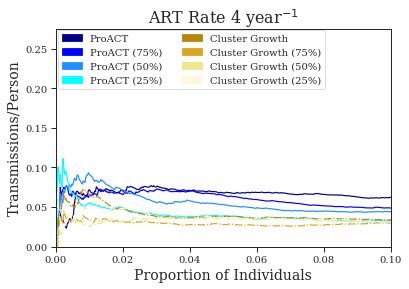

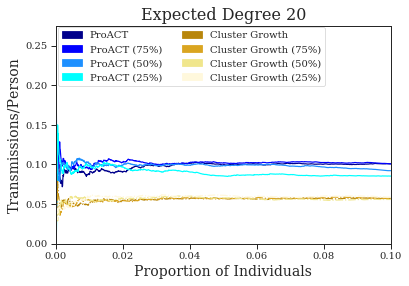

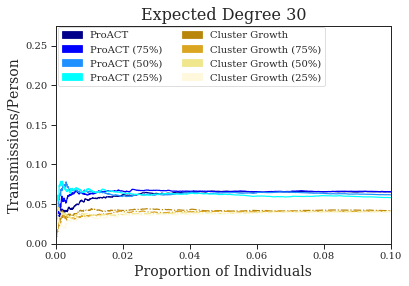

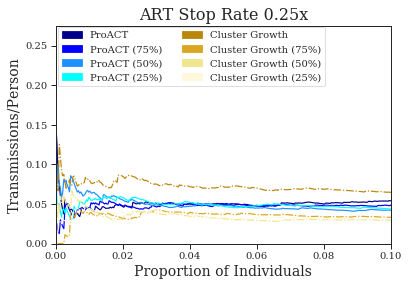

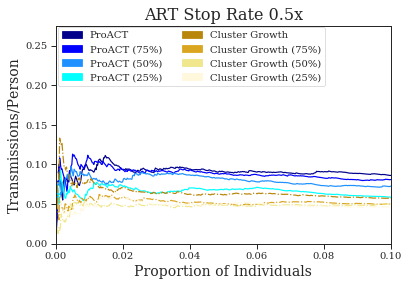

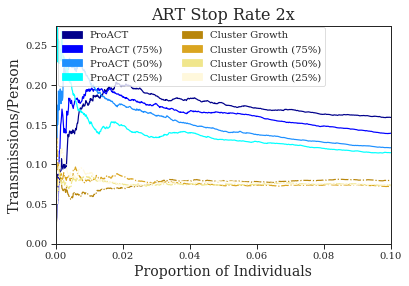

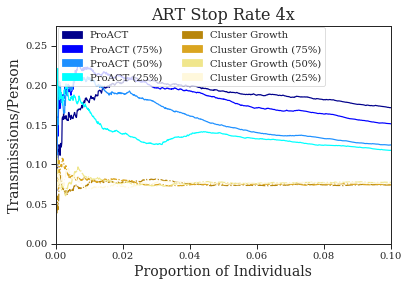

In [14]:
Ms = ['proact.ftmv','proact.ftmv.sub75','proact.ftmv.sub50','proact.ftmv.sub25','hivtrace','hivtrace.sub75','hivtrace.sub50','hivtrace.sub25']
Ks = ['SAMPLE-FIRSTART_ARTRATE-1','SAMPLE-FIRSTART_ARTRATE-2','SAMPLE-FIRSTART_ARTRATE-4','SAMPLE-FIRSTART_EXPDEGREE-20','SAMPLE-FIRSTART_EXPDEGREE-30','SAMPLE-FIRSTART_STOPRATE-0.25x','SAMPLE-FIRSTART_STOPRATE-0.5x','SAMPLE-FIRSTART_STOPRATE-2x','SAMPLE-FIRSTART_STOPRATE-4x']
XMAX = {K:min(min(len(l) for l in eff[m][K]) for m in Ms) for K in Ks}
xmin = 0
xmax = 0.1
ymin = 0
ymax = 0.275
handles = [Patch(color=metasim['color'][m], label=metasim['label'][m]) for m in Ms]
for K in Ks:
    rand_cmas = {m:[cma(l[:XMAX[K]]) for l in eff[m][K]] for m in eff if m.startswith('random')}
    rand_y = {m:[avg([c[i] for c in rand_cmas[m]]) for i in range(XMAX[K])] for m in eff if m.startswith('random')}
    opt_cmas = {m:[cma(l[:XMAX[K]]) for l in eff[m][K]] for m in eff if m.startswith('optimal')}
    opt_y = {m:[avg([c[i] for c in opt_cmas[m]])-rand_y[m.replace('optimal','random')][i] for i in range(XMAX[K])] for m in eff if m.startswith('optimal')}
    fig = plt.figure()
    for m in Ms:
        prefix = m.split('.sub')[0]
        cmas = [cma(l[:XMAX[K]]) for l in eff[m][K]]
        y = [avg([c[i] for c in cmas]) for i in range(XMAX[K])]
        x = [float(i)/XMAX[K] for i in range(len(y))]
        plt.plot(x, y, color=metasim['color'][m], linestyle=metasim['linestyle'][m], label=metasim['label'][m])
    plt.legend(handles=handles, bbox_to_anchor=(0.005, 0.995), loc=2, ncol=2, borderaxespad=0.)
    #plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
    plt.xlim(xmin=xmin,xmax=xmax)
    plt.ylim(ymin=ymin,ymax=ymax)
    plt.title(metasim['label'][K])
    plt.xlabel("Proportion of Individuals")
    plt.ylabel("Transmissions/Person")
    fig.savefig('%s/results_efficacy_%s.pdf'%(FIGDIR,K), format='pdf', bbox_inches='tight')
    if K == 'SAMPLE-FIRSTART_ARTRATE-1':
        for altK in ['SAMPLE-FIRSTART_EXPDEGREE-10','SAMPLE-FIRSTART_STOPRATE-1x']:
            plt.title(metasim['label'][altK])
            fig.savefig('%s/results_efficacy_%s.pdf'%(FIGDIR,altK), format='pdf', bbox_inches='tight')

### Comparing Methods (Normalized)

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/usr/loc

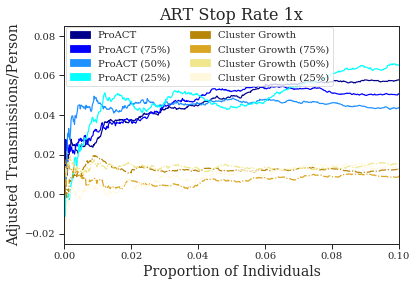

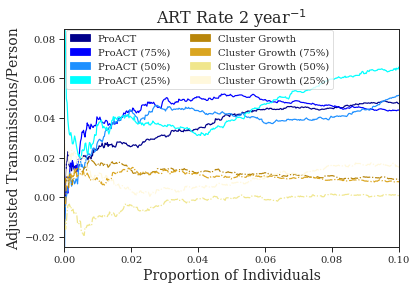

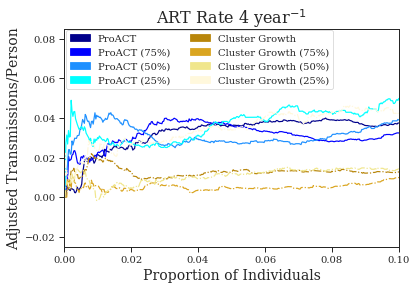

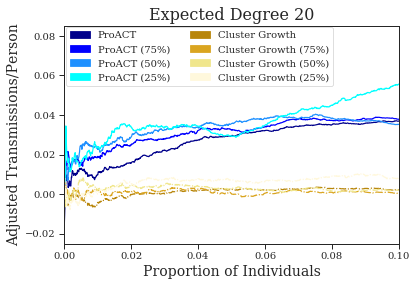

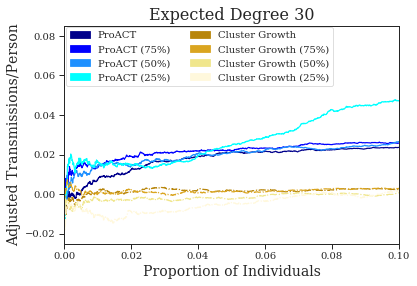

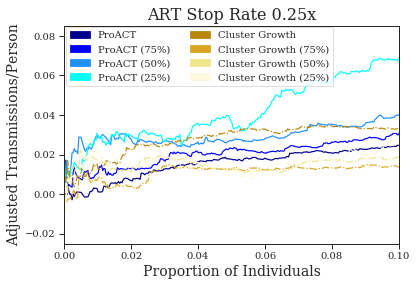

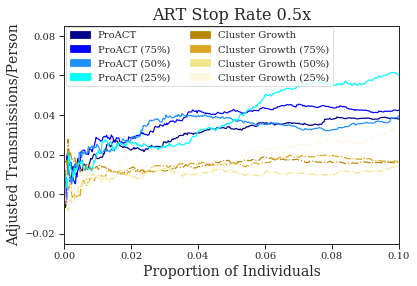

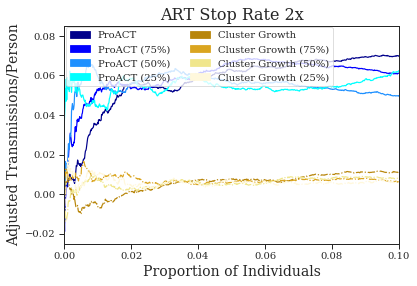

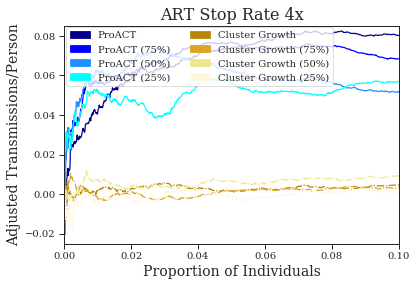

In [15]:
Ms = ['proact.ftmv','proact.ftmv.sub75','proact.ftmv.sub50','proact.ftmv.sub25','hivtrace','hivtrace.sub75','hivtrace.sub50','hivtrace.sub25']
Ks = ['SAMPLE-FIRSTART_ARTRATE-1','SAMPLE-FIRSTART_ARTRATE-2','SAMPLE-FIRSTART_ARTRATE-4','SAMPLE-FIRSTART_EXPDEGREE-20','SAMPLE-FIRSTART_EXPDEGREE-30','SAMPLE-FIRSTART_STOPRATE-0.25x','SAMPLE-FIRSTART_STOPRATE-0.5x','SAMPLE-FIRSTART_STOPRATE-2x','SAMPLE-FIRSTART_STOPRATE-4x']
XMAX = {K:min(min(len(l) for l in eff[m][K]) for m in Ms) for K in Ks}
xmin = 0
xmax = 0.1
ymin = -0.025
ymax = 0.085
handles = [Patch(color=metasim['color'][m], label=metasim['label'][m]) for m in Ms]
for K in Ks:
    rand_cmas = {m:[cma(l[:XMAX[K]]) for l in eff[m][K]] for m in eff if m.startswith('random')}
    rand_y = {m:[avg([c[i] for c in rand_cmas[m]]) for i in range(XMAX[K])] for m in eff if m.startswith('random')}
    opt_cmas = {m:[cma(l[:XMAX[K]]) for l in eff[m][K]] for m in eff if m.startswith('optimal')}
    opt_y = {m:[avg([c[i] for c in opt_cmas[m]])-rand_y[m.replace('optimal','random')][i] for i in range(XMAX[K])] for m in eff if m.startswith('optimal')}
    fig = plt.figure()
    for m in Ms:
        prefix = m.split('.sub')[0]
        cmas = [cma(l[:XMAX[K]]) for l in eff[m][K]]
        y = [(avg([c[i] for c in cmas])-rand_y[m.replace(prefix,'random')][i])/opt_y[m.replace(prefix,'optimal')][i] for i in range(XMAX[K])]
        x = [float(i)/XMAX[K] for i in range(len(y))]
        plt.plot(x, y, color=metasim['color'][m], linestyle=metasim['linestyle'][m], label=metasim['label'][m])
    plt.legend(handles=handles, bbox_to_anchor=(0.005, 0.995), loc=2, ncol=2, borderaxespad=0.)
    #plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
    plt.xlim(xmin=xmin,xmax=xmax)
    plt.ylim(ymin=ymin,ymax=ymax)
    plt.title(metasim['label'][K])
    plt.xlabel("Proportion of Individuals")
    plt.ylabel("Adjusted Transmissions/Person")
    fig.savefig('%s/results_efficacy_normalized_%s.pdf'%(FIGDIR,K), format='pdf', bbox_inches='tight')
    if K == 'SAMPLE-FIRSTART_ARTRATE-1':
        for altK in ['SAMPLE-FIRSTART_EXPDEGREE-10','SAMPLE-FIRSTART_STOPRATE-1x']:
            plt.title(metasim['label'][altK])
            fig.savefig('%s/results_efficacy_normalized_%s.pdf'%(FIGDIR,altK), format='pdf', bbox_inches='tight')

### Comparing Model Conditions

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


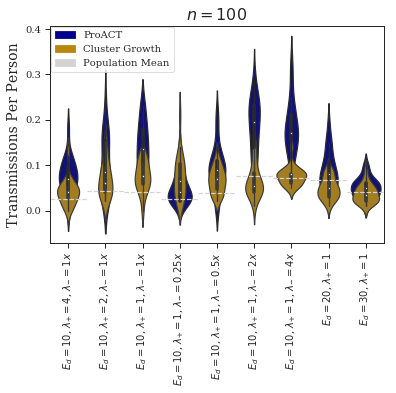

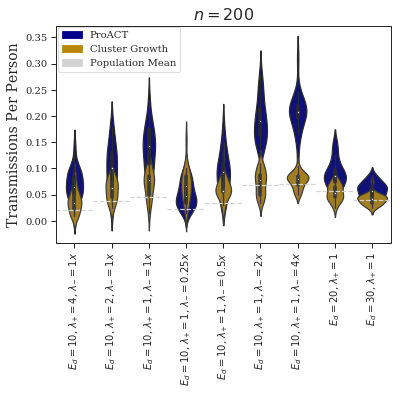

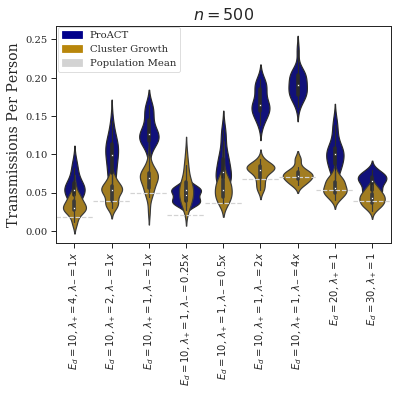

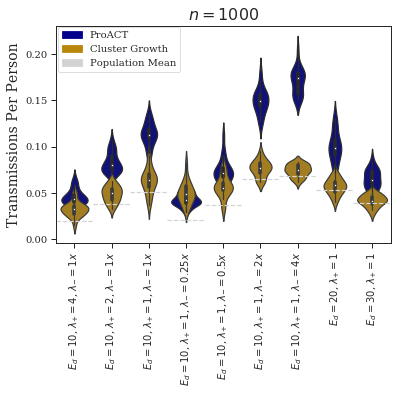

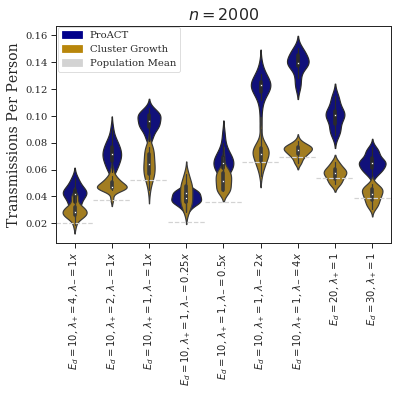

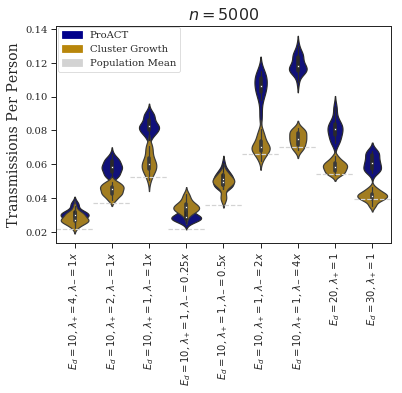

In [16]:
Ks = ['SAMPLE-FIRSTART_ARTRATE-4','SAMPLE-FIRSTART_ARTRATE-2','SAMPLE-FIRSTART_ARTRATE-1','SAMPLE-FIRSTART_STOPRATE-0.25x','SAMPLE-FIRSTART_STOPRATE-0.5x','SAMPLE-FIRSTART_STOPRATE-2x','SAMPLE-FIRSTART_STOPRATE-4x','SAMPLE-FIRSTART_EXPDEGREE-20','SAMPLE-FIRSTART_EXPDEGREE-30']
tr = {
    'SAMPLE-FIRSTART_ARTRATE-1': r'$E_{d}=10$, $\lambda_{+}=1$, $\lambda_{-}=1x$',
    'SAMPLE-FIRSTART_ARTRATE-2': r'$E_{d}=10$, $\lambda_{+}=2$, $\lambda_{-}=1x$',
    'SAMPLE-FIRSTART_ARTRATE-4': r'$E_{d}=10$, $\lambda_{+}=4$, $\lambda_{-}=1x$',
    'SAMPLE-FIRSTART_STOPRATE-0.25x': r'$E_{d}=10$, $\lambda_{+}=1$, $\lambda_{-}=0.25x$',
    'SAMPLE-FIRSTART_STOPRATE-0.5x': r'$E_{d}=10$, $\lambda_{+}=1$, $\lambda_{-}=0.5x$',
    'SAMPLE-FIRSTART_STOPRATE-2x': r'$E_{d}=10$, $\lambda_{+}=1$, $\lambda_{-}=2x$',
    'SAMPLE-FIRSTART_STOPRATE-4x': r'$E_{d}=10$, $\lambda_{+}=1$, $\lambda_{-}=4x$',
    'SAMPLE-FIRSTART_EXPDEGREE-20': r'$E_{d}=20$, $\lambda_{+}=1$',
    'SAMPLE-FIRSTART_EXPDEGREE-30': r'$E_{d}=30$, $\lambda_{+}=1$',
    'SAMPLE-END_ARTRATE-1': r'$E_{d}=10$, $\lambda_{+}=1$, $\lambda_{-}=1x$ (End)',
    'SAMPLE-END_ARTRATE-2': r'$E_{d}=10$, $\lambda_{+}=2$, $\lambda_{-}=1x$ (End)',
    'SAMPLE-END_ARTRATE-4': r'$E_{d}=10$, $\lambda_{+}=4$, $\lambda_{-}=1x$ (End)',
}
Ms = ['proact.ftmv','hivtrace']
Ns = [100,200,500,1000,2000,5000]
handles = [Patch(color=metasim['color'][m], label=metasim['label'][m]) for m in Ms+['expected']]
ymin = None #-0.05
ymax = None #0.8
for n in Ns:
    fig = plt.figure()
    for m in Ms:
        x = list(); y = list()
        for K in Ks:
            y += [avg(l[:n]) for l in eff[m][K]]; x += [tr[K]]*len(eff[m][K])
        violinplot(x=x, y=y, color=metasim['color'][m], labels=metasim['label'][m])
    xlim = plt.xlim()
    for m in ['random']:
        for i,K in enumerate(Ks):
            x = [i-0.5,i+0.5]; y = [avg([avg(l[:n]) for l in eff[m][K]])]*2
            plt.plot(x, y, linestyle=metasim['linestyle'][m], color=metasim['color'][m])
    plt.legend(handles=handles, bbox_to_anchor=(0.005, 0.995), loc=2, borderaxespad=0.)
    plt.xlim(xlim)
    plt.ylim(ymin=ymin,ymax=ymax)
    plt.title(r"$n=%d$" % n)
    plt.ylabel("Transmissions Per Person")
    plt.xticks(rotation=90)
    fig.savefig('%s/results_efficacy_n%d.pdf'%(FIGDIR,n), format='pdf', bbox_inches='tight')

# Miscellaneous

## Helper Functions

In [17]:
def L2N(l):
    return l.label.split('|')[1]

In [18]:
def read_lines(filename):
    if filename == 'stdin':
        return [l.strip() for l in stdin.read().strip().splitlines()]
    elif filename.lower().endswith('.gz'):
        return [l.strip() for l in gopen(filename).read().decode().strip().splitlines()]
    else:
        return [l.strip() for l in open(filename).read().strip().splitlines()]

In [19]:
def load_transmissions(filename):
    trans = []; nodes = set()
    for l in read_lines(filename):
        try:
            u,v,t = l.split(); t = float(t)
        except:
            raise RuntimeError("Invalid transmission network")
        trans.append((u,v,t))
    return trans

In [20]:
def load_diag_times(filename):
    diag = dict()
    for l in read_lines(filename):
        u,t = l.strip().split('\t')
        if u.count('|') == 2: # virus|person|time identifiers
            u = u.split('|')[1]
        diag[u] = float(t)
    return diag

In [21]:
def leaf_to_name(tree):
    tr = dict()
    for l in tree.traverse_leaves():
        if l.label.count('|') == 2: # virus|person|time identifiers
            tr[l] = l.label.split('|')[1]
        else:
            tr[l] = l.label
    return tr

In [22]:
def individual_efficacy(user_individuals,transmissions,from_time,to_time):
    assert to_time > from_time, "To Time must be larger than From Time"
    eff = {u:0 for u in user_individuals}; trans_nodes = set()
    for u,v,t in transmissions:
        trans_nodes.add(u); trans_nodes.add(v)
        if t >= from_time and t <= to_time and u in eff:
            eff[u] += 1
    for u in eff:
        assert u in trans_nodes, "Individual not in transmission network: %s"%u
    return eff

In [23]:
def compute_max_sibling_leaf_time(tree,inf):
    max_inf = dict()
    for u in tree.traverse_postorder():
        if u.is_leaf():
            max_inf[u] = inf[L2N(u)]
        else:
            max_inf[u] = max(max_inf[c] for c in u.children)
    out = dict()
    for u in tree.traverse_postorder():
        if u.is_root():
            out[u] = None
        else:
            out[u] = max(max_inf[c] for c in u.parent.children if c != u)
    return out

In [24]:
def edgelength_over_time(tree,inf): # each element in list for a given leaf is (time,length) tuple
    el_t = dict(); max_sib_inf = compute_max_sibling_leaf_time(tree,inf); oldest_leaf = dict()
    # compute (oldest_time,leaf) tuples for each node
    for u in tree.traverse_postorder():
        if u.is_leaf():
            oldest_leaf[u] = (inf[L2N(u)],u)
        else:
            oldest_leaf[u] = min(oldest_leaf[c] for c in u.children)
    # compute edge length over time
    for u in tree.traverse_postorder():
        if u.is_leaf():
            if inf[L2N(u)] >= max_sib_inf[u]:
                el_t[u] = [[inf[L2N(u)],u.edge_length]]
            else:
                el_t[u] = [[max_sib_inf[u],u.edge_length]]
        else:
            if u.edge_length is None:
                el = 0
            else:
                el = u.edge_length
            if u.is_root():
                prev_time = oldest_leaf[u][0]
            else:
                prev_time = min(oldest_leaf[c] for c in u.parent.children if oldest_leaf[c][1] != oldest_leaf[u][1])[0]
            if prev_time >= oldest_leaf[u][0] and prev_time < el_t[oldest_leaf[u][1]][-1][0]:
                el_t[oldest_leaf[u][1]].append([prev_time,el_t[oldest_leaf[u][1]][-1][1]])
            el_t[oldest_leaf[u][1]][-1][1] += el
    for l in el_t:
        if el_t[l][-1][0] > inf[L2N(l)]:
            el_t[l][-1][0] = inf[L2N(l)]
    return {l:el_t[l][::-1] for l in el_t}

In [25]:
def plot_edgelength_over_time(el_t,eff,max_num_lines,xmin=None,xmax=None,ymin=None,ymax=None,xlabel='Time',ylabel='Edge Length',title='Edge Length vs. Time',filename=None):
    fig = plt.figure()
    leaves = sorted(el_t.keys(), key=lambda a: eff[L2N(a)])
    if max_num_lines is not None:
        leaves = leaves[-max_num_lines:]
    min_eff = min(eff[L2N(l)] for l in leaves); max_eff = max(eff[L2N(l)] for l in leaves); max_time = max(el_t[l][-1][0] for l in leaves)
    norm = Normalize(vmin=min_eff, vmax=max_eff, clip=True); color_mapper = ScalarMappable(norm=norm, cmap=Reds)
    handles = [Patch(color=color_mapper.to_rgba(e), label='%d Transmission(s)'%e) for e in (min_eff,max_eff)]
    for l in leaves:
        pairs = el_t[l]
        x = [pairs[0][0]]; y = [pairs[0][1]] # start (just a point)
        for t,el in pairs[1:]:
            x.append(t); y.append(y[-1]) # bring it forward
            x.append(t); y.append(el) # bring it up
        x.append(max_time); y.append(y[-1])
        plt.plot(x, y, color=color_mapper.to_rgba(eff[L2N(l)]))
    plt.legend(handles=handles, bbox_to_anchor=(0.995, 0.995), loc=1, borderaxespad=0.)
    plt.xlim(xmin=xmin,xmax=xmax); plt.ylim(ymin=ymin,ymax=ymax)
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.tight_layout(); plt.show()
    if filename is not None:
        fig.savefig('%s/%s'%(FIGDIR,filename), format='pdf', bbox_inches='tight')

## Load Raw Simulated Data

In [26]:
tr = {
    'true': 'True',
    'ftmv': 'Inferred',
}
simdata = dict()
for folder in glob('../simulations/SAMPLE-FIRSTART_ARTRATE-1'):
    experiment = folder.split('/')[-1]; simdata[experiment] = dict()
    for transfile in glob('%s/*.transmissions.txt.gz'%folder):
        r = transfile.split('/')[-1].split('.')[0]
        simdata[experiment][r] = {'true': read_tree_newick(transfile.replace('transmissions.txt','true.time9.tre')),
                              'ftmv': read_tree_newick(transfile.replace('transmissions.txt','ft.mv.time9.tre'))}
        simdata[experiment][r]['diag'] = load_diag_times(transfile.replace('transmissions','diagnosis'))
        simdata[experiment][r]['eff'] = individual_efficacy([L2N(l) for l in simdata[experiment][r]['true'].traverse_leaves()],
                                                       load_transmissions(transfile),9,float('inf'))

## Plot Edgelength Over Time

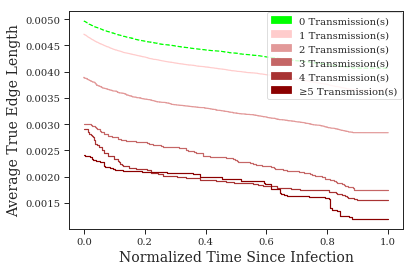

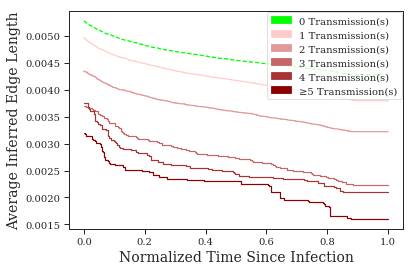

In [27]:
MAXBINSIZE = 10000
def average_edgelenth_over_time_people(el_t):
    el_t = {k:el_t[k] for k in sample(list(el_t.keys()),min(MAXBINSIZE,len(el_t.keys())))} # subsample because it's too slow
    fixed_el_t = [[[(t-v[0][0])/(SIMTIME-v[0][0]),el] for t,el in v] for v in el_t.values()]
    out = [[t,0.] for t in sorted({t for v in fixed_el_t for t,el in v})]
    for v in fixed_el_t: # for each person's vector of edge-length windows
        i = len(out)-1 # start at last time
        for t,el in v[::-1]: # iterate over this person's times in reverse order
            while i >= 0 and t <= out[i][0]:
                out[i][1] += el; i -= 1
    for i in range(len(out)):
        out[i][1] /= len(fixed_el_t)
    return out

def eff_color(e):
    if e == 0:
        return '#00FF00'
    elif e == 1:
        return '#FFCCCC'
    elif e == 2:
        return '#E29999'
    elif e == 3:
        return '#C56666'
    elif e == 4:
        return '#A83333'
    elif e >= 5:
        return '#8b0000'
    else:
        raise ValueError("Invalid efficacy")
ls = lambda x: {True:'--',False:'-'}[x == 0]
eff_bin = lambda x: {True:x,False:5}[x < 5]
tr = {'ftmv':'Inferred','true':'True'}

experiment = 'SAMPLE-FIRSTART_ARTRATE-1'
unique_effs = set(e for r in simdata[experiment] for e in simdata[experiment][r]['eff'].values())
min_eff,max_eff = [f(unique_effs) for f in [min,max]]
handles = [Patch(color=eff_color(e), label='%d Transmission(s)'%e) for e in range(5)]
handles.append(Patch(color=eff_color(5), label='≥5 Transmission(s)'))
for k in ['true','ftmv']:
    fig = plt.figure()
    merged_el_t_by_eff = {e:dict() for e in range(6)}
    for r in simdata[experiment]:
        curr_el_t = edgelength_over_time(simdata[experiment][r][k], simdata[experiment][r]['diag'])
        for l,v in curr_el_t.items():
            merged_el_t_by_eff[eff_bin(simdata[experiment][r]['eff'][L2N(l)])]['%s_%s'%(r,l)] = v
    for e in merged_el_t_by_eff:
        avg_el_t = average_edgelenth_over_time_people(merged_el_t_by_eff[e])
        x = [avg_el_t[0][0]]; y = [avg_el_t[0][1]] # start (just a point)
        for t,el in avg_el_t[1:]:
            x.append(t); y.append(y[-1]) # bring it forward
            x.append(t); y.append(el) # bring it down
        x.append(1); y.append(y[-1]) # bring it to end
        plt.plot(x, y, color=eff_color(e), linestyle=ls(e))
    plt.legend(handles=handles, bbox_to_anchor=(0.995, 0.995), loc=1, borderaxespad=0.)
    plt.xlabel("Normalized Time Since Infection")
    plt.ylabel("Average %s Edge Length"%tr[k])
    fig.savefig('%s/avg_edgelength_vs_time_%s.pdf'%(FIGDIR,k), format='pdf', bbox_inches='tight')

## Plot Edge Length vs. Efficacy

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


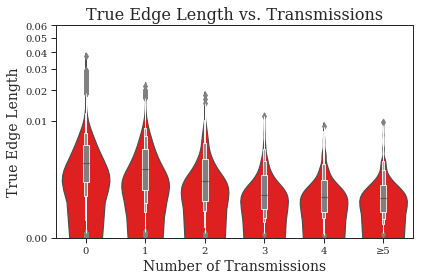

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


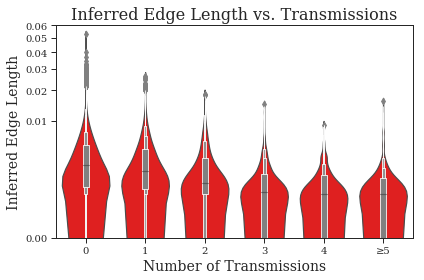

In [28]:
exp_color = {'SAMPLE-FIRSTART_ARTRATE-1':'red'}
experiment = 'SAMPLE-FIRSTART_ARTRATE-1'
ymin = 0; ymax = 0.06
MAXBINSIZE = 1000
point_color = 'grey'
f = lambda x: {True:str(x), False:'≥5'}[x<5]
for k in ['true','ftmv']:
    fig = plt.figure()
    el_vs_eff = dict()
    for r in simdata[experiment]:
        for l in simdata[experiment][r][k].traverse_leaves():
            e = simdata[experiment][r]['eff'][L2N(l)]
            if e not in el_vs_eff:
                el_vs_eff[e] = list()
            el_vs_eff[e].append(l.edge_length)
    #el_vs_eff = {e:sample(v, min(MAXBINSIZE,len(v))) for e,v in el_vs_eff.items()} # subsample if too slow
    x = list(); y = list()
    for e in el_vs_eff:
        x += [f(e)]*len(el_vs_eff[e])
        y += el_vs_eff[e]
    violinplot(x=x, y=y, color=exp_color[experiment], scale='width', bw=0.3, inner=None)
    boxenplot(x=x, y=y, color=point_color, width=0.1)
    plt.ylim(ymin=ymin,ymax=ymax)
    plt.yscale('cuberoot')
    plt.xlabel('Number of Transmissions'); plt.ylabel('%s Edge Length'%tr[k]); plt.title("%s Edge Length vs. Transmissions"%tr[k])
    plt.tight_layout(); plt.show()
    fig.savefig('%s/edgelength_vs_efficacy_%s.pdf'%(FIGDIR,k), format='pdf', bbox_inches='tight')